# Bigram model

In [187]:
import torch
import matplotlib.pyplot as plt

In [188]:
names = open('names.txt','r').read().splitlines()
names[:3]

['emma', 'olivia', 'ava']

In [189]:
for n in names[:3]:
    n = '.' + n + '.'
    print(n)
    for c1, c2 in zip(n,n[1:]):
        print(f'{c1}{c2}')

.emma.
.e
em
mm
ma
a.
.olivia.
.o
ol
li
iv
vi
ia
a.
.ava.
.a
av
va
a.


In [190]:
names_ = names[:]
chars = sorted(list(set((''.join(names_)))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}
nc = len(stoi)
counts = torch.zeros(nc,nc,dtype=torch.int32)
for n in names_:
    n = '.' + n + '.'
    for c1, c2 in zip(n,n[1:]):
        row = stoi[c1]
        col = stoi[c2]
        counts[row,col] += 1

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)


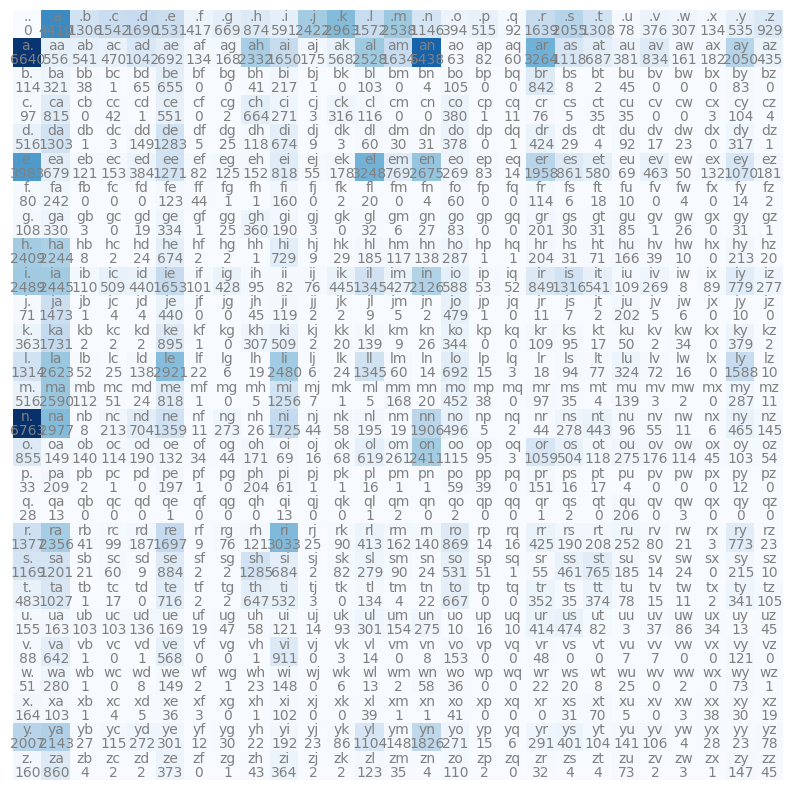

In [191]:
def plot_counts(counts, nc):
    plt.figure(figsize=(10,10))
    plt.imshow(counts,cmap='Blues')
    for i in range(nc):
        for j in range(nc):
            bigram = itos[j] + itos[i]
            plt.text(i, j, bigram, ha='center', va='bottom', color='gray')
            plt.text(i, j, counts[j,i].item(), ha='center', va='top', color='gray')
    plt.axis('off')

plot_counts(counts, nc)
print(counts[0])

In [192]:
# generating probability distribution from counts
# by normalising with the the sum of each row
# +1 for regularisation so no probabilities are 0 as this leads to -inf log lik
p = (counts + 1) / (counts + 1).sum(1, keepdim=True)
print(p[0])

def make_name_bigram(p, i):
    g = torch.Generator().manual_seed(2147483647+i)
    row = 0
    name = ''
    while True:
        p_ = p[row]
        row = torch.multinomial(p_, num_samples=1, replacement=True, generator=g).item()
        name += itos[row]
        if row == 0:
            break
    
    return name

tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])


In [193]:
for i in range(10):
    print(make_name_bigram(p, i))

junide.
can.
lyli.
ali.
jh.
cari.
arinenaa.
kyn.
r.
keleeentowistin.


In [194]:
# predicted probabilities of bigram occurrance
loglik = 0
N = 0
for n in names[:]:
    n = '.' + n + '.'
    for c1, c2 in zip(n,n[1:]):
        row = stoi[c1]
        col = stoi[c2]
        ppred_log = -torch.log(p[row, col])
        loglik += ppred_log
        N += 1

loglik / N

tensor(2.4544)

# Neural network

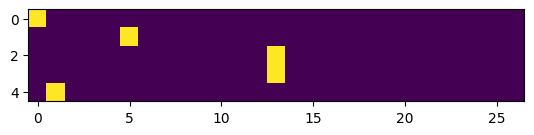

In [195]:
import torch.nn.functional as F

def training_data(n):
    X, y = [], []
    
    for name in names[:n]:
        name = '.' + name + '.'
        for c1, c2 in zip(name,name[1:]):
            row = stoi[c1]
            col = stoi[c2]
            X.append(row) # for this input
            y.append(col) # this is the desired output
            
    X = torch.tensor(X)
    y = torch.tensor(y)
    
    # one hot encoding assigns each instance of a
    # categorical variable to a location in a vector
    X_onehot = F.one_hot(X, num_classes=27).float()

    return X_onehot, y

X_onehot, y = training_data(1)

plt.imshow(X_onehot) # each corresponding bit of the vector is switched on

**Designing a weight matrix**

Suppose X : (5, 27), then X @ W : (5,27) @ (27,27) = (5,27). If W were (27,1), that would computing the activation for a single neuron. With 27 rows in W, we are compute the activation for all 27 neurons. If X were (1, 27), that would be computing the forward pass for a single intput, but with 5 rows, we are computing the forward pass for all inputs 27 neurons because we want a probability for all 27 characters, i.e. one neuron to compute the probabilty for each character.

In [196]:
W = torch.randn(27, 27, requires_grad=True)
act = X_onehot @ W
print(act.shape, ': 5 inputs and their outputs, each with 27 probability columns, each col is the prob for that char') 

torch.Size([5, 27]) : 5 inputs and their outputs, each with 27 probability columns, each col is the prob for that char


In [198]:
logits = act.exp()
p = logits / logits.sum(1, keepdim=True) # this and last line compute the softmax
N = p.shape[0]
logloss = -p_nn[torch.arange(N), y].log().mean()
logloss

tensor(3.6829, grad_fn=<NegBackward0>)

In [199]:
X_onehot, y = training_data(None)
N = X_onehot.shape[0]
W = torch.randn(27, 27, requires_grad=True)
losses = []

tensor(2.4592, grad_fn=<NegBackward0>)


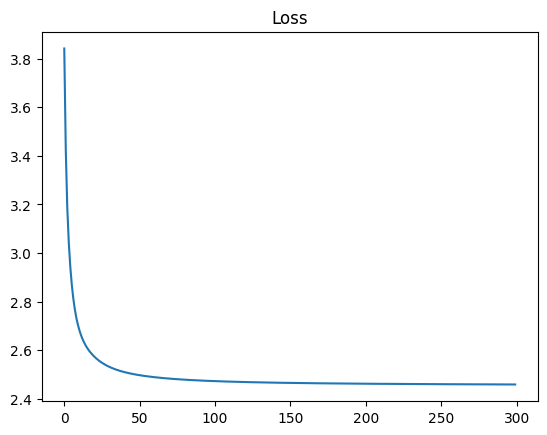

In [200]:
a = 50
for e in range(300):
    act = X_onehot @ W
    logits = act.exp()
    p = logits / logits.sum(1, keepdim=True)
    logloss = -p[torch.arange(N), y].log().mean() # indexing the right char probabilty
    W.grad = None
    logloss.backward()
    W.data -= a * W.grad
    losses.append(logloss.item())

plt.plot(losses)
plt.title('Loss')
print(logloss)

In [201]:
def make_name_nn(W, i):
    g = torch.Generator().manual_seed(2147483647+i)
    row = 0
    name = ''
    while True:
        x_onehot = F.one_hot(torch.tensor([row]), num_classes=27).float()
        act = x_onehot @ W
        logits = act.exp()
        p = logits / logits.sum(1, keepdim=True)
        row = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        name += itos[row]
        if row == 0:
            break
    
    return name

for i in range(10):
    print(make_name_nn(W, i))

junide.
can.
lyli.
ali.
jh.
cari.
arinenaa.
kyn.
r.
keleeentowistin.
